# Titanic Machine Learning from Disaster

This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

## The Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer

## Datasets

In [2]:
# Load data from the csv file
df_train = pd.read_csv("Datasets/train.csv", index_col=0)

# Information about the dataframe
print("Number of rows/observations: {}".format(df_train.shape[0]))
print("Number of colums/features: {}".format(df_train.shape[1]))
df_train.head()

Number of rows/observations: 891
Number of colums/features: 11


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Load holdout data
holdout = pd.read_csv("Datasets/test.csv", index_col=0)

# Information about the dataframe
print("Number of rows/observations: {}".format(holdout.shape[0]))
print("Number of colums/features: {}".format(holdout.shape[1]))
holdout.head()

Number of rows/observations: 418
Number of colums/features: 10


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
df = pd.concat([df_train.drop(['Survived'], axis=1), holdout])
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratoy Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 112.5+ KB


In [6]:
# Type of the feature
df.dtypes.value_counts()

object     5
int64      3
float64    2
dtype: int64

In [7]:
# Brief description about the dataframe
features = pd.DataFrame(columns=["Feature", "Number of unique values", "Values"])

for i, feature in enumerate(df.columns):
    features.loc[i] = [feature, df[feature].nunique(), df[feature].unique().tolist()]
    
description = pd.read_csv("Datasets/description.csv", index_col=0) 
features.set_index("Feature").join(description)

,Number of unique values,Values,Definition,Key
Feature,,,,
Pclass,3,"[3, 1, 2]",Ticket class,"1 = 1st, 2 = 2nd, 3 = 3rd"
Name,1307,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B...",NaN,NaN
Sex,2,"[male, female]",Sex,NaN
Age,98,"[22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,...",Age in years,NaN
SibSp,7,"[1, 0, 3, 4, 2, 5, 8]",NaN,NaN
Parch,8,"[0, 1, 2, 5, 3, 4, 6, 9]",# of parents / children aboard the Titanic,NaN
Ticket,929,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803...",Ticket number,NaN
Fare,281,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....",Passenger fare,NaN
Cabin,186,"[nan, C85, C123, E46, G6, C103, D56, A6, C23 C...",Cabin number,NaN


## Missing values

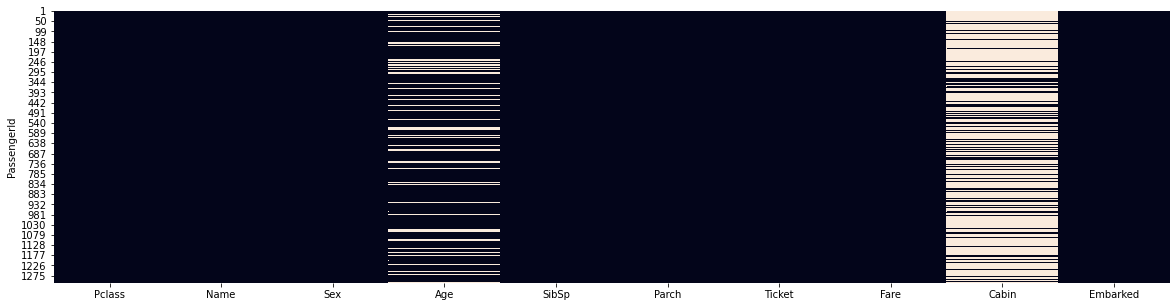

In [8]:
plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [9]:
# Number of missing values by feaure
df.isna().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [10]:
for i, value in enumerate(df.isna().sum()):
    if value != 0:
        print('{} has {} missing values and represent {:.2f}%'.format(df.isna().sum().index[i], value, (value/df.shape[0])*100))

Age has 263 missing values and represent 20.09%
Fare has 1 missing values and represent 0.08%
Cabin has 1014 missing values and represent 77.46%
Embarked has 2 missing values and represent 0.15%


**Insights**:

- Cabin has 687 missing values what represents a 77.10% of the total of observations. So the best option is to eliminate the feature.
- Age has 177 missign values could do an imputation
- Embarked has 2 missing values because they are just two, we can do an imputation or eliminate this rows
- Fare has 1 missing value, we can do an imputation

## Duplicate values

In [11]:
df.reset_index()[df.reset_index().duplicated(["PassengerId"])]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


**Insights**:

- There are not duplicated values in the dataframe, because there are not reapeated id's.

## Numerical features

In [12]:
df.select_dtypes(include=np.number).describe()

,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


In [13]:
cols_num = df.select_dtypes(np.number).columns.tolist()
cols_num

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

### Box plots

In [14]:
def box_plot(cols, df):
    fig, axes = plt.subplots(2,3, figsize=(15,5))
    for col, ax in zip(cols, axes.ravel()):
        sns.boxplot(data=df, x=col, ax=ax)
        plt.xlabel(col)
    
    plt.suptitle("Box plots of features")
    fig.delaxes(axes[1,2])
    plt.tight_layout()
    plt.show()

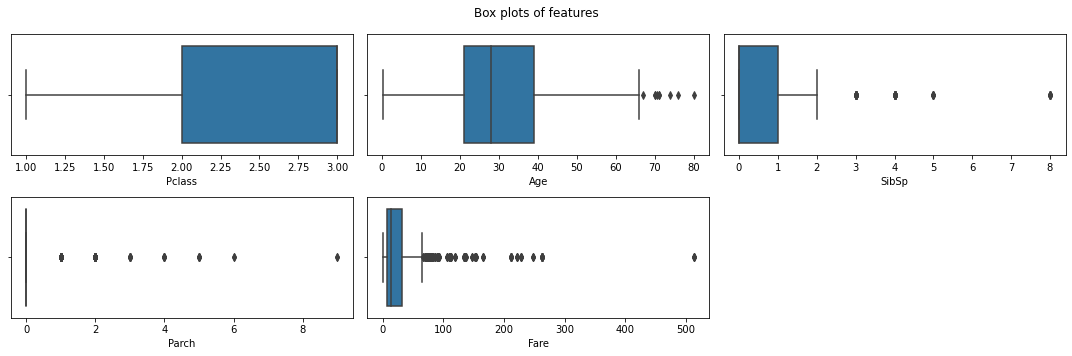

In [15]:
box_plot(cols_num, df)   

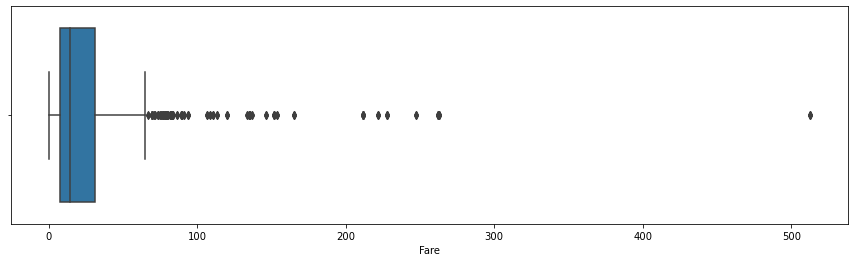

In [16]:
plt.figure(figsize=(15,4))
sns.boxplot(data=df, x="Fare")
plt.show()

**Insights**:

- There seems to be a rate higher than 500, so it could be an outlier.

### Distribution plots

In [17]:
# Check the distribution of numerical features in the original dataset
def distributions(cols, df):
    fig, axes = plt.subplots(2,3, figsize=(15,5))
    for col, ax in zip(cols, axes.ravel()):
        sns.histplot(data=df, x=col, ax=ax)
        plt.xlabel(col)
    
    plt.suptitle("Distribution of features")
    fig.delaxes(axes[1,2])
    plt.tight_layout()
    plt.show()

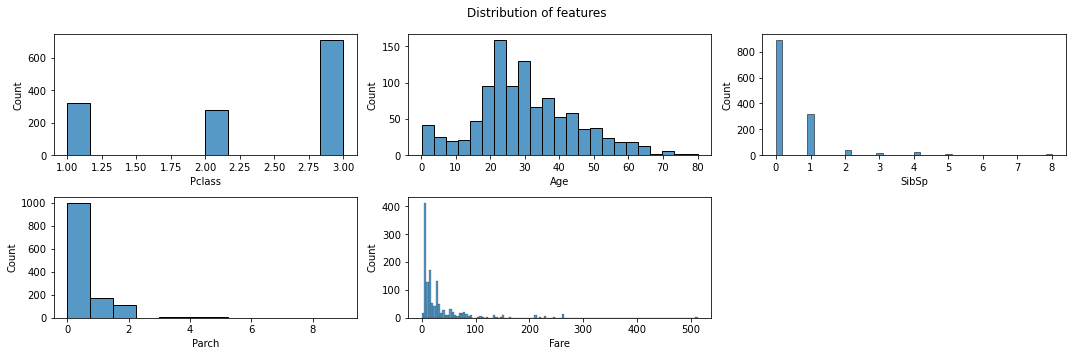

In [18]:
distributions(cols_num, df)    

**Insights**:

- Pclass: There are more third class passengers than the other two classes.
- Age: Age presents approximately a normal distribution.
- SibSp: Most of the passengers did not have a husband or wife on board the Titanic.
- Parch: Most of the passengers had no relatives or children aboard the Titanic.
- Fare: We can see that it is skewed to the left, this is due to the fact that class 3 costs are lower than the other classes and there are more passengers in this class.


### Multi-collinearity

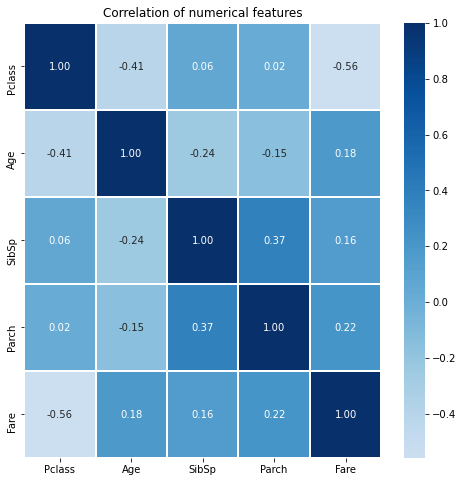

In [19]:
# Correlation of numerical features
plt.figure(figsize=(8,8))
plt.title('Correlation of numerical features')
sns.heatmap(df[cols_num].corr(), annot=True, fmt='.2f', cmap='Blues',  center=0, linewidths=1)
plt.show()

**Insights**:

- There seems to a medium correlation between Fare - Pclass and Age - Pclass. They are not so strongly correlated so we can use them

## Categorical features

In [20]:
df.select_dtypes(include='object').describe()

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


In [21]:
cols_cat = df.drop(['Name','Cabin', 'Ticket'], axis=1).select_dtypes(include='object').columns.to_list()
cols_cat

['Sex', 'Embarked']

In [22]:
def plot_cat(cols, df):
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    for col, ax in zip(cols, axes.ravel()):
        sns.countplot(data=df, x=col, ax=ax)
        plt.xlabel(col)
    
    plt.suptitle("Distribution of categorical features")
    plt.tight_layout()
    plt.show()    

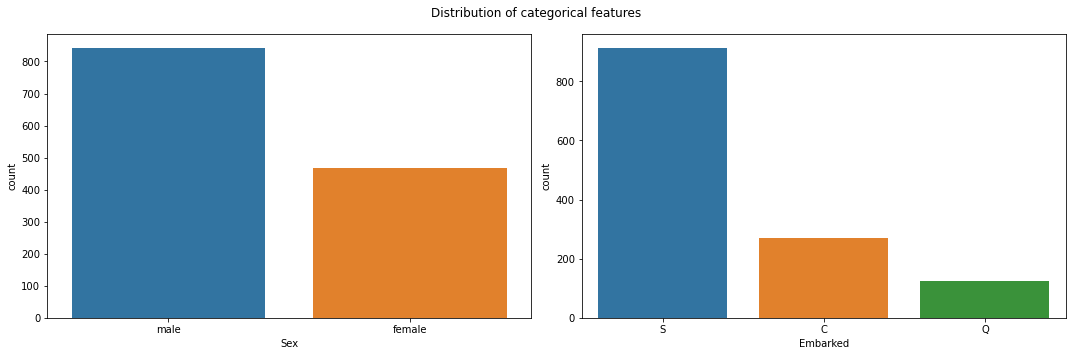

In [23]:
plot_cat(cols_cat, df)

## Target feature

In [24]:
df_train['Survived'].describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

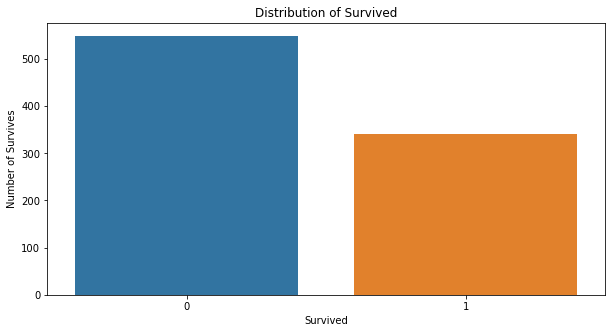

In [25]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="Survived", data=df_train)
plt.title("Distribution of Survived")
plt.ylabel("Number of Survives")
plt.show()

# Analysis Data

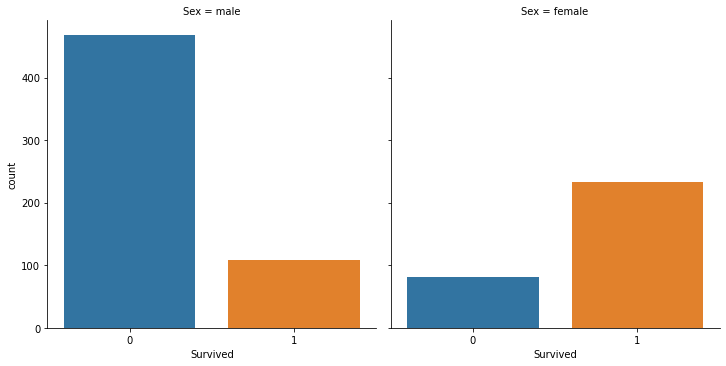

In [26]:
sns.catplot(x='Survived', col='Sex', kind='count', data=df_train)
plt.show()

In [27]:
df_train.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

**Insights**:

- It seems that females are more likely to survive

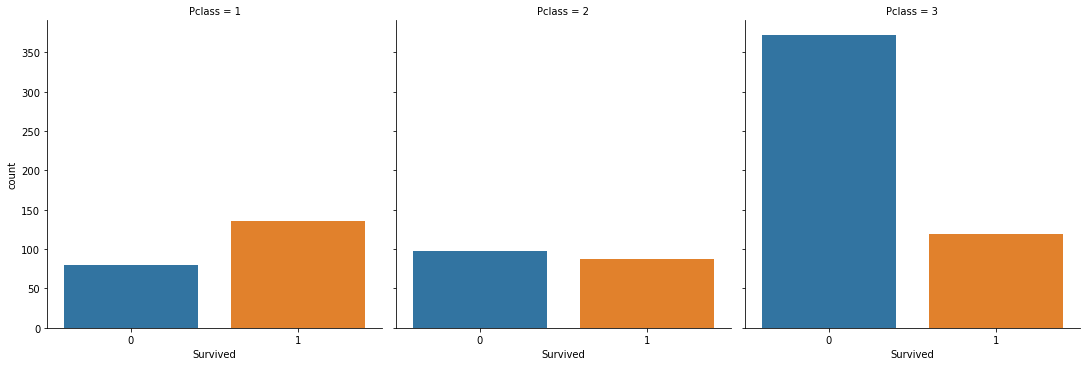

In [28]:
sns.catplot(x='Survived', col='Pclass', kind='count', data=df_train)
plt.show()

In [29]:
df_train.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

**Insights**:

- Class 1 passengers were most likely to survive, followed by second class and third class.

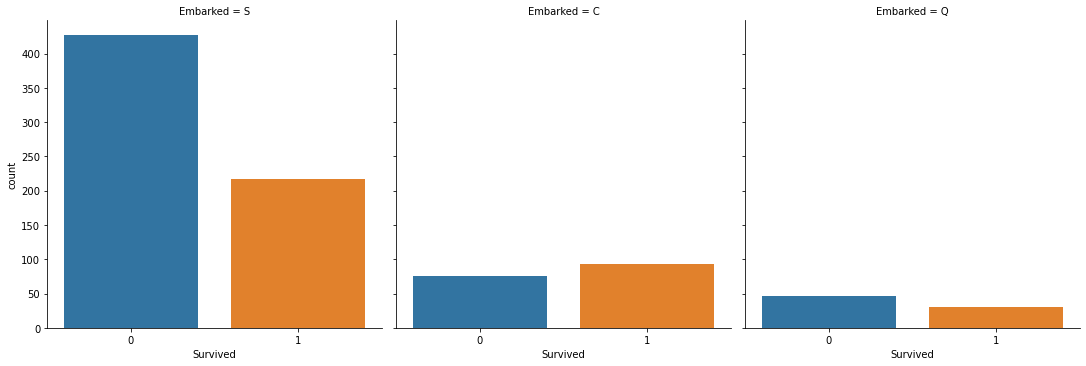

In [30]:
sns.catplot(x='Survived', col='Embarked', kind='count', data=df_train)
plt.show()

In [31]:
df_train.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

**Insights**:

- The largest proportion of surviving passengers embarked on C

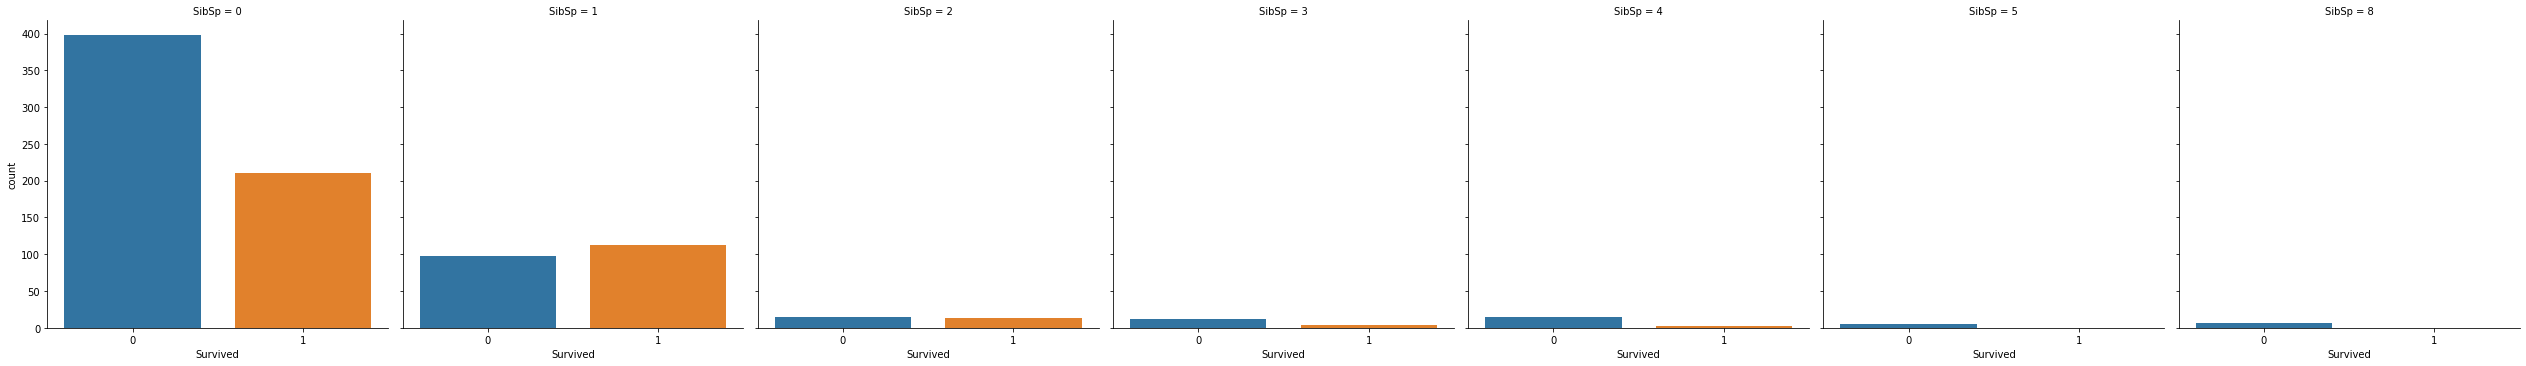

In [32]:
sns.catplot(x='Survived', col='SibSp', kind='count', data=df_train)
plt.show()

In [33]:
df_train.groupby('SibSp')['Survived'].mean().sort_values(ascending=False)

SibSp
1    0.535885
2    0.464286
0    0.345395
3    0.250000
4    0.166667
8    0.000000
5    0.000000
Name: Survived, dtype: float64

**Insights**:

- As we can see the highest proportion of surviving passengers were those who had 1 or 2 siblings/spouses on board the Titanic.

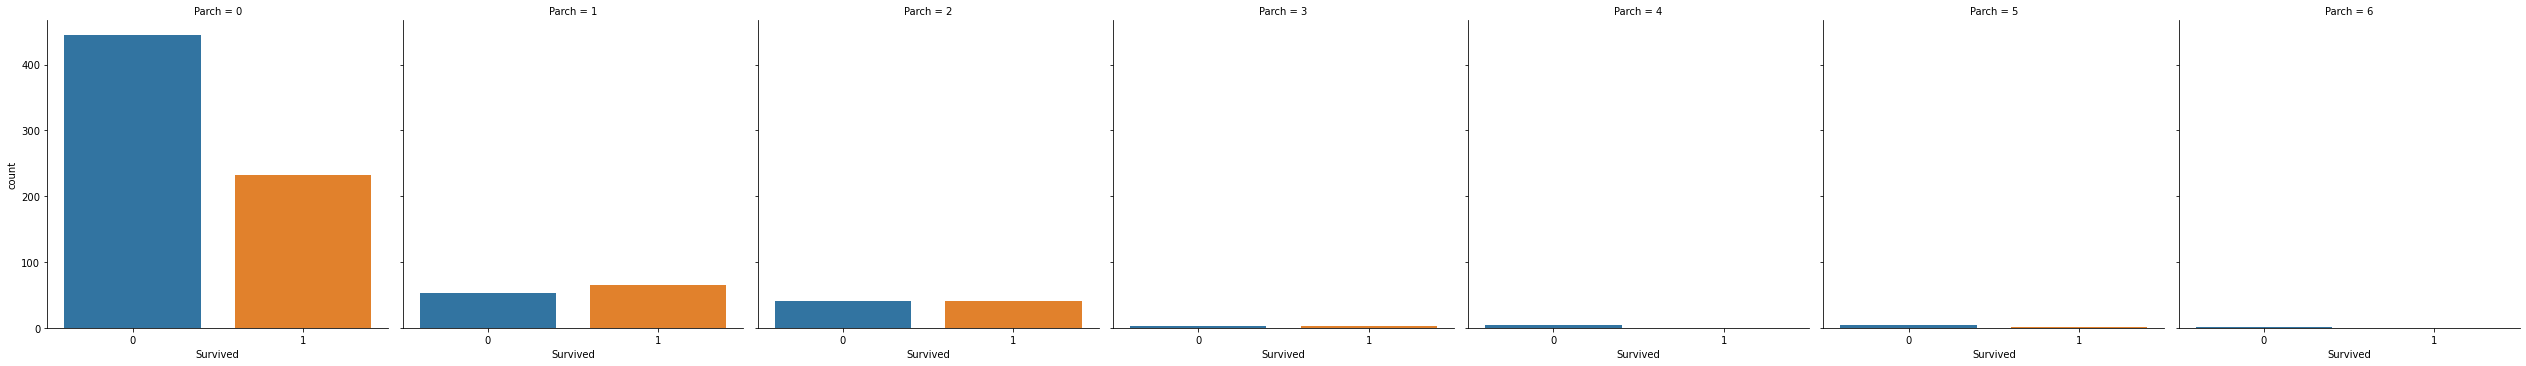

In [34]:
sns.catplot(x='Survived', col='Parch', kind='count', data=df_train)
plt.show()

In [35]:
df_train.groupby('Parch')['Survived'].mean().sort_values(ascending=False)

Parch
3    0.600000
1    0.550847
2    0.500000
0    0.343658
5    0.200000
6    0.000000
4    0.000000
Name: Survived, dtype: float64

**Insights**:

- As we can see the highest proportion of surviving passengers were those who had 3, 1, or 2 parents/children on board the Titanic.

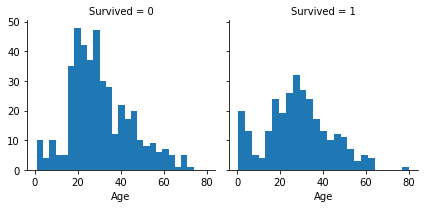

In [36]:
g = sns.FacetGrid(df_train, col='Survived')
g.map(plt.hist, 'Age', bins=25)
plt.show()

**Insights**:

- The majority of passengers are between the ages of 15 and 30. Children under 10 years old had a high survival rate, the 80 year old passenger survived.

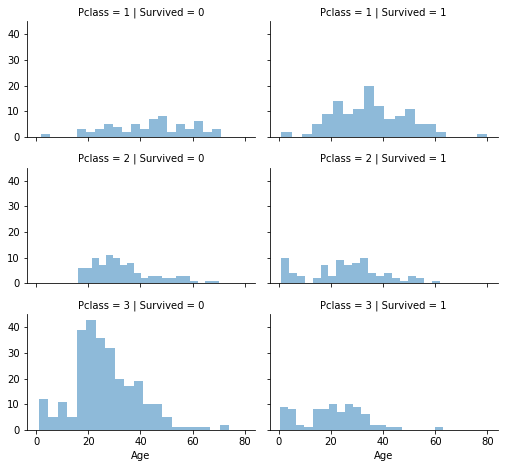

In [37]:
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()
plt.show()

**Insights**:

- As can be seen in the most distinctive cases. A greater number of first class passengers of all ages survived, rather than all between the ages of 20 and 40, while in third class most of the passengers who did not survive were under 40.
- Class 3 had the most passengers but most did not survive. The minors in class 1 and 2 all survived.  

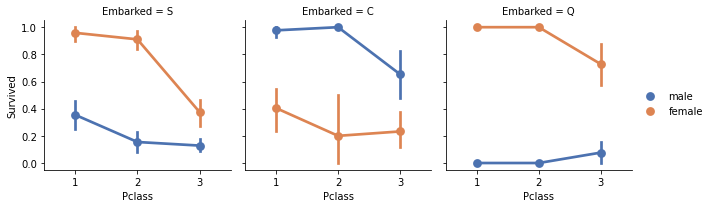

In [38]:
grid = sns.FacetGrid(df_train, col='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()
plt.show()

**Insights**:

- As can be seen in the trends, most of the passengers who survived were women who boarded at boarding S and Q, except at boarding C where more men than women survived.

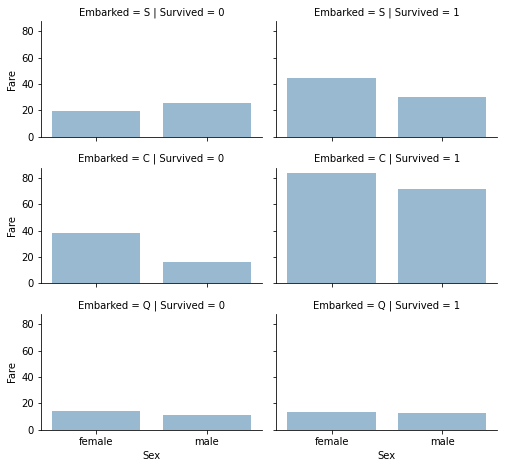

In [39]:
grid = sns.FacetGrid(df_train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()
plt.show()

**Insights**:

- Passengers who pay higher fares have a higher probability of survival

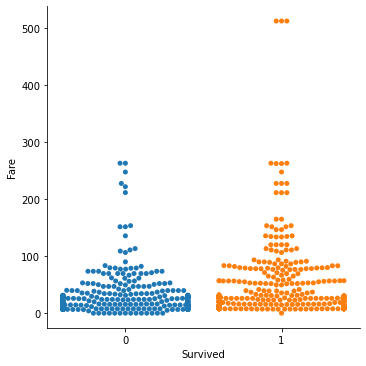

In [40]:
sns.catplot(x = "Survived", y = "Fare", data = df_train, kind = "swarm")
plt.show()

**Insights**:

- It seems that more passengers who paid more for their ticket were saved.

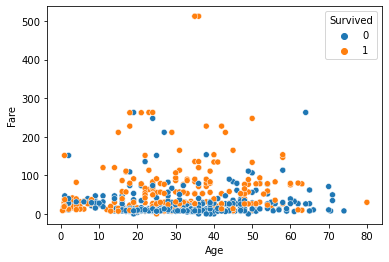

In [41]:
sns.scatterplot(data=df_train, x="Age", y="Fare", hue="Survived")
plt.show()

**Insights**:

- As far as can be seen, more young people survived than older people.

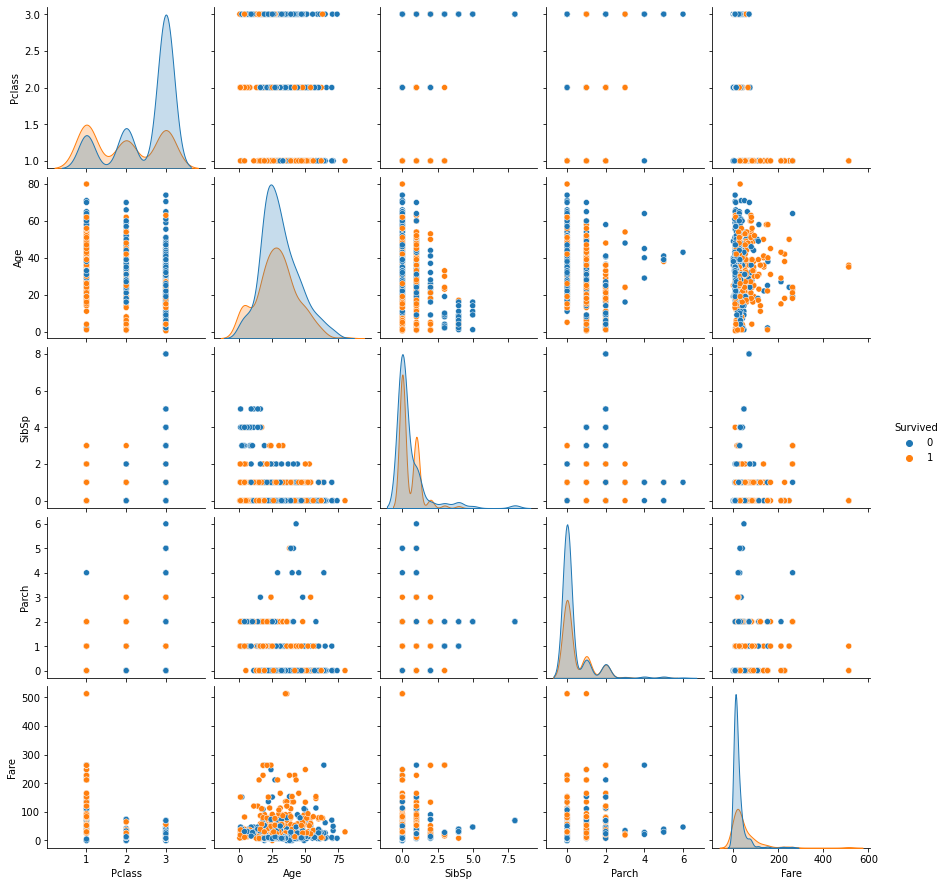

In [42]:
sns.pairplot(df_train, hue="Survived")
plt.show()

# Feature Engineering & Data Cleaning

## Imputation

In [43]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)

In [44]:
df.isna().sum()

Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin       1014
Embarked       0
dtype: int64

## Outlier

In [45]:
df[df['Fare']>500]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
259,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
738,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
1235,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C


**Insights**:

- It would seem that if the fare is greater than 500 it is an outlier but there are three fares greater than 500 in the training data and one in the test data. So they do not appear to be outliers.

## Feature: Name

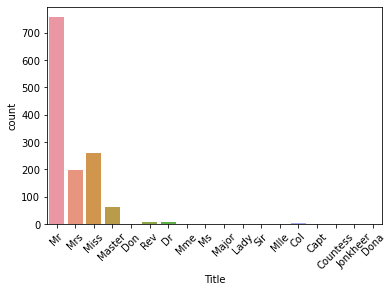

In [46]:
df['Title'] = df.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=df)
plt.xticks(rotation=45)
plt.show()

**Insights**:

- There are many titles, we can reduce them to a smaller group

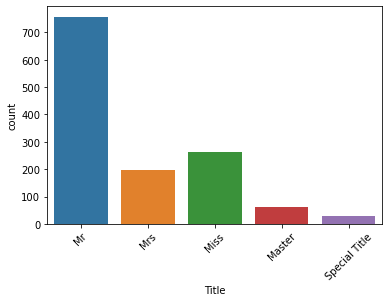

In [47]:
df['Title'] = df['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
df['Title'] = df['Title'].replace(['Don', 'Dona', 'Rev', 'Dr',
                                   'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'], 'Special Title')
sns.countplot(x='Title', data=df)
plt.xticks(rotation=45)
plt.show()

In [48]:
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


## Feature: Cabin

In [49]:
df['has_cabin'] = ~df['Cabin'].isnull()
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,has_cabin
PassengerId,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False


**Insights**:

- Cabin has a lot of missing values, we can think that those missing values are passengers that didn't have a cabin. This could give of us some information.

## Feature: Group by Age

In [50]:
df['Group_Age'] = pd.qcut(df['Age'], q=4, labels=False)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,has_cabin,Group_Age
PassengerId,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True,3
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True,2
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False,2


## Feature: Group by Fare

In [51]:
df['Group_Fare'] = pd.qcut(df['Fare'], q=4, labels=False)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,has_cabin,Group_Age,Group_Fare
PassengerId,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False,0,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True,3,3
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False,1,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True,2,3
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False,2,1


## Feature: Family Size

In [52]:
df['Fam_size']= df[['SibSp','Parch']].sum(axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,has_cabin,Group_Age,Group_Fare,Fam_size
PassengerId,,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True,3,3,1
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False,1,1,0
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True,2,3,1
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False,2,1,0


## Drop

In [53]:
df.drop(['Cabin', 'Name', 'Ticket', 'Age', 'Fare'], axis=1, inplace=True)
df.head()

,Pclass,Sex,SibSp,Parch,Embarked,Title,has_cabin,Group_Age,Group_Fare,Fam_size
PassengerId,,,,,,,,,,
1,3,male,1,0,S,Mr,False,0,0,1
2,1,female,1,0,C,Mrs,True,3,3,1
3,3,female,0,0,S,Miss,False,1,1,0
4,1,female,1,0,S,Mrs,True,2,3,1
5,3,male,0,0,S,Mr,False,2,1,0


## Separate dataframes

In [54]:
X = pd.get_dummies(df)
X.head()

,Pclass,SibSp,Parch,has_cabin,Group_Age,Group_Fare,Fam_size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Special Title
PassengerId,,,,,,,,,,,,,,,,,
1,3,1,0,False,0,0,1,0,1,0,0,1,0,0,1,0,0
2,1,1,0,True,3,3,1,1,0,1,0,0,0,0,0,1,0
3,3,0,0,False,1,1,0,1,0,0,0,1,0,1,0,0,0
4,1,1,0,True,2,3,1,1,0,0,0,1,0,0,0,1,0
5,3,0,0,False,2,1,0,0,1,0,0,1,0,0,1,0,0


In [55]:
# Split into test and train
X_train_ = X.iloc[:891]
X_train_.head()

,Pclass,SibSp,Parch,has_cabin,Group_Age,Group_Fare,Fam_size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Special Title
PassengerId,,,,,,,,,,,,,,,,,
1,3,1,0,False,0,0,1,0,1,0,0,1,0,0,1,0,0
2,1,1,0,True,3,3,1,1,0,1,0,0,0,0,0,1,0
3,3,0,0,False,1,1,0,1,0,0,0,1,0,1,0,0,0
4,1,1,0,True,2,3,1,1,0,0,0,1,0,0,0,1,0
5,3,0,0,False,2,1,0,0,1,0,0,1,0,0,1,0,0


In [56]:
X_test_ = X.iloc[891:]
X_test_.head()

,Pclass,SibSp,Parch,has_cabin,Group_Age,Group_Fare,Fam_size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Special Title
PassengerId,,,,,,,,,,,,,,,,,
892,3,0,0,False,2,0,0,0,1,0,1,0,0,0,1,0,0
893,3,1,0,False,3,0,1,1,0,0,0,1,0,0,0,1,0
894,2,0,0,False,3,1,0,0,1,0,1,0,0,0,1,0,0
895,3,0,0,False,1,1,0,0,1,0,0,1,0,0,1,0,0
896,3,1,1,False,0,1,2,1,0,0,0,1,0,0,0,1,0


In [57]:
y = df_train['Survived']
y.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

# Modeling

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_train_, y, test_size=0.3, random_state=27, stratify=y)

In [59]:
def predict(ml_model, mode):
    
    if mode==0:
        model = ml_model.fit(X_train, y_train)
    else:
        model = ml_model
        
    print('Training Score: {}'.format(model.score(X_train, y_train)))
    print('\n')
    
    predictions = model.predict(X_test)
    print('Five first Predictions are: {}'.format(predictions[:5]))
    print('Five first Real values are: {}'.format(y_test.values[:5]))
    print('\n')
    
    acc = accuracy_score(y_test, predictions)
    print('Accuracy Score is: {}'.format(acc))
    print('Precision Score is: {}'.format(precision_score(y_test, predictions)))
    print('ROC AUC Score is: {}'.format(roc_auc_score(y_test, predictions)))
    print('\n')
    
    print(classification_report(y_test, predictions))
    print('\n')
    
    #Confusion Matrix
    cm = confusion_matrix(y_test, predictions)    
    fig, axes = plt.subplots(1,3, figsize=(20,5))
    sns.heatmap(cm, annot=True, fmt='g', ax=axes[0])
    axes[0].set_title('Confusion Matrix', fontsize=16)

    # ROC_curve
    fpr_lr, tpr_lr, _ = roc_curve(y_test, predictions)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    closest_zero = np.argmin(np.abs(fpr_lr - 0.16))
    closest_zero_fpr_lr = fpr_lr[closest_zero]
    closest_zero_tpr_lr = tpr_lr[closest_zero]

    axes[1].set_xlim([-0.01, 1.00])
    axes[1].set_ylim([-0.01, 1.01])
    axes[1].plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
    axes[1].plot(closest_zero_fpr_lr, closest_zero_tpr_lr, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
    axes[1].set_xlabel('False Positive Rate', fontsize=16)
    axes[1].set_ylabel('True Positive Rate', fontsize=16)
    axes[1].set_title('ROC curve', fontsize=16)
    axes[1].legend(loc='lower right', fontsize=13)
    axes[1].plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    axes[1].set_aspect('equal')    
    
    # precision recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, predictions)
    closest_zero = np.argmin(np.abs(precision - 0.75))
    closest_zero_p = precision[closest_zero]
    closest_zero_r = recall[closest_zero]
    
    axes[2].set_xlim([0.0, 1.01])
    axes[2].set_ylim([0.0, 1.01])
    axes[2].plot(precision, recall, label='Precision-Recall Curve')
    axes[2].plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
    axes[2].set_title('Precision Recall curve', fontsize=16)
    axes[2].set_xlabel('Precision', fontsize=16)
    axes[2].set_ylabel('Recall', fontsize=16)
    axes[2].set_aspect('equal')    
        
    plt.show()
    
    return model, acc

## LogisticRegression

Training Score: 0.8330658105939005


Five first Predictions are: [0 1 0 0 1]
Five first Real values are: [0 1 1 1 1]


Accuracy Score is: 0.8134328358208955
Precision Score is: 0.7572815533980582
ROC AUC Score is: 0.8028832009414534


              precision    recall  f1-score   support

           0       0.85      0.85      0.85       165
           1       0.76      0.76      0.76       103

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268





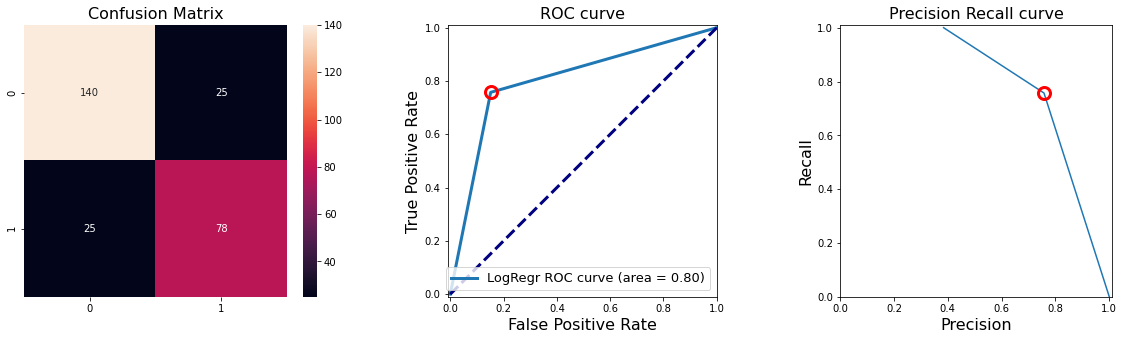

Wall time: 862 ms


In [60]:
%%time
lr, lr_acc = predict(LogisticRegression(),0)

## Support Vector Machines

Training Score: 0.8314606741573034


Five first Predictions are: [0 1 0 0 1]
Five first Real values are: [0 1 1 1 1]


Accuracy Score is: 0.832089552238806
Precision Score is: 0.8152173913043478
ROC AUC Score is: 0.8125625183877612


              precision    recall  f1-score   support

           0       0.84      0.90      0.87       165
           1       0.82      0.73      0.77       103

    accuracy                           0.83       268
   macro avg       0.83      0.81      0.82       268
weighted avg       0.83      0.83      0.83       268





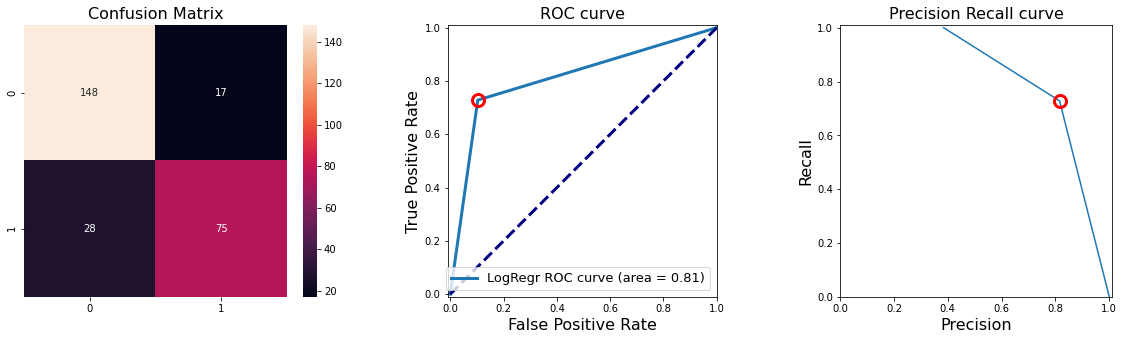

Wall time: 851 ms


In [61]:
%%time
svc, svc_acc = predict(SVC(),0)

## KNeighborsClassifier

Training Score: 0.8651685393258427


Five first Predictions are: [0 1 0 0 1]
Five first Real values are: [0 1 1 1 1]


Accuracy Score is: 0.8134328358208955
Precision Score is: 0.7523809523809524
ROC AUC Score is: 0.8047072668431892


              precision    recall  f1-score   support

           0       0.85      0.84      0.85       165
           1       0.75      0.77      0.76       103

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268





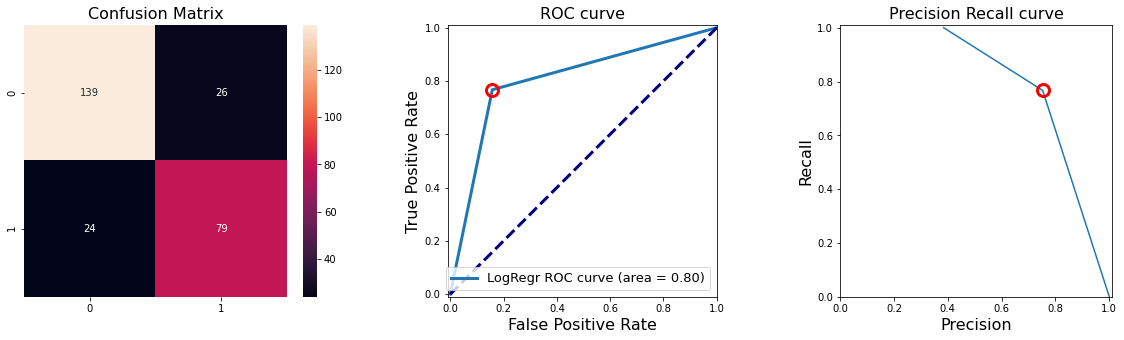

Wall time: 862 ms


In [62]:
%%time
knc, knc_acc = predict(KNeighborsClassifier(n_neighbors = 3),0)

## Decision Tree

Training Score: 0.9149277688603531


Five first Predictions are: [0 1 0 0 1]
Five first Real values are: [0 1 1 1 1]


Accuracy Score is: 0.8059701492537313
Precision Score is: 0.7524752475247525
ROC AUC Score is: 0.7931744630773758


              precision    recall  f1-score   support

           0       0.84      0.85      0.84       165
           1       0.75      0.74      0.75       103

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.81      0.81      0.81       268





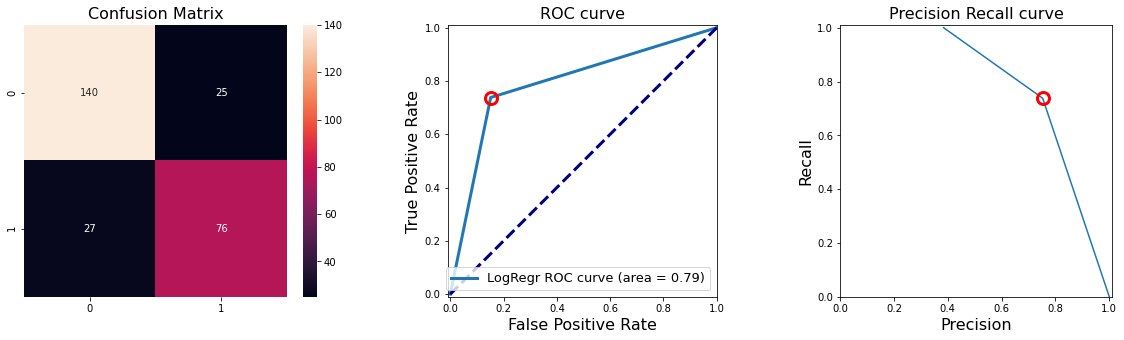

Wall time: 816 ms


In [63]:
%%time
dtc, dtc_acc = predict(DecisionTreeClassifier(),0)

## RandomForestClassifier

Training Score: 0.9149277688603531


Five first Predictions are: [0 1 0 0 1]
Five first Real values are: [0 1 1 1 1]


Accuracy Score is: 0.8022388059701493
Precision Score is: 0.7314814814814815
ROC AUC Score is: 0.7956163577522801


              precision    recall  f1-score   support

           0       0.85      0.82      0.84       165
           1       0.73      0.77      0.75       103

    accuracy                           0.80       268
   macro avg       0.79      0.80      0.79       268
weighted avg       0.80      0.80      0.80       268





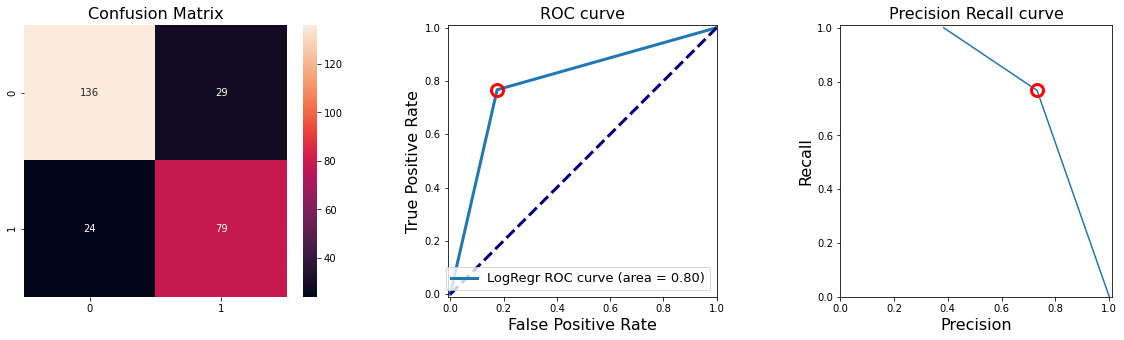

Wall time: 1.49 s


In [64]:
%%time
rfc, rfc_acc = predict(RandomForestClassifier(),0)

## GradientBoostingClassifier

Training Score: 0.8715890850722311


Five first Predictions are: [0 1 0 0 0]
Five first Real values are: [0 1 1 1 1]


Accuracy Score is: 0.8171641791044776
Precision Score is: 0.7755102040816326
ROC AUC Score is: 0.8022653721682849


              precision    recall  f1-score   support

           0       0.84      0.87      0.85       165
           1       0.78      0.74      0.76       103

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.82      0.82      0.82       268





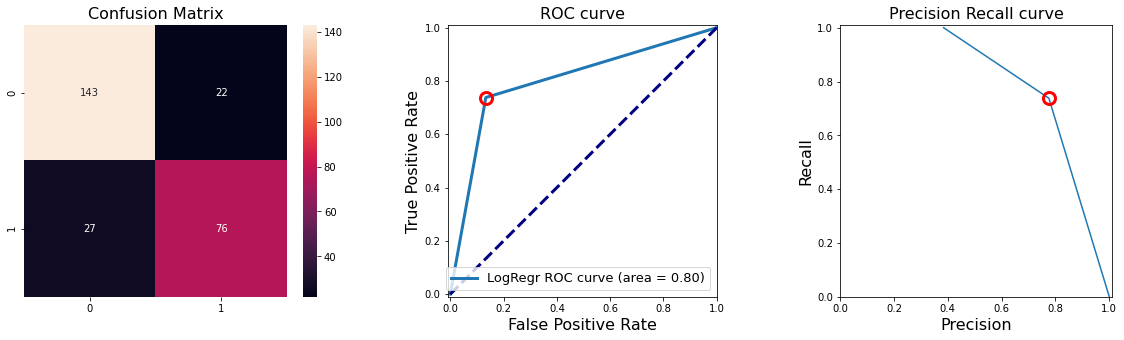

Wall time: 1.34 s


In [65]:
%%time
gbc, gbc_acc = predict(GradientBoostingClassifier(),0)

## Accuracy of the models

In [66]:
models = pd.DataFrame({
    'Model': ['LogisticRegression', 'Support Vector Machines', 'KNN', 
              'Decision Tree', 'Random Forest', 'GradientBoostingClassifier'],
    'Score': [lr_acc, svc_acc, knc_acc, 
              dtc_acc, rfc_acc, gbc_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,Support Vector Machines,0.832090
5,GradientBoostingClassifier,0.817164
0,LogisticRegression,0.813433
2,KNN,0.813433
3,Decision Tree,0.805970
4,Random Forest,0.802239


**Insights**:

- The two best models were Support Vector Machines and GradientBoostingClassifier

# Hyper tuning

In [67]:
clf_SVC = SVC()

param_grid_SVC = {'C': [1, 10, 100], 
                  'gamma': [0.001, 0.01, 1]}


gs_SVC = GridSearchCV(clf_SVC, param_grid_SVC, scoring='accuracy', cv=5)

In [68]:
%%time
gs_SVC.fit(X_train_, y)

Wall time: 1.55 s


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'gamma': [0.001, 0.01, 1]},
             scoring='accuracy')

In [69]:
# Print the tuned parameter and score
print("Tuned Parameters: {}".format(gs_SVC.best_params_))
print("Best score is {}".format(gs_SVC.best_score_))

Tuned Parameters: {'C': 10, 'gamma': 0.01}
Best score is 0.8327474734793798


Training Score: 0.8330658105939005


Five first Predictions are: [0 1 0 0 1]
Five first Real values are: [0 1 1 1 1]


Accuracy Score is: 0.8395522388059702
Precision Score is: 0.8191489361702128
ROC AUC Score is: 0.8222712562518388


              precision    recall  f1-score   support

           0       0.85      0.90      0.87       165
           1       0.82      0.75      0.78       103

    accuracy                           0.84       268
   macro avg       0.83      0.82      0.83       268
weighted avg       0.84      0.84      0.84       268





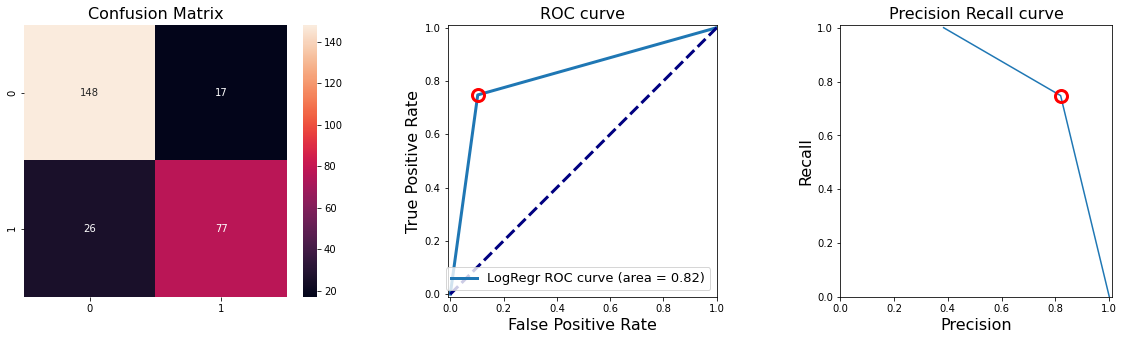

Wall time: 896 ms


In [70]:
%%time
svc, svc_acc = predict(gs_SVC,1)

## GradientBoostingClassifier

In [71]:
clf_GBC = GradientBoostingClassifier()

#creating Scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall':make_scorer(recall_score)}


param_grid_GBC = {"n_estimators": [10,100, 300, 500],
                  #"learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
                  #"min_samples_split": np.linspace(0.1, 0.5, 12),
                  #"min_samples_leaf": np.linspace(0.1, 0.5, 12),
                  "max_depth": [3, 5, 10, 15, 20, 'auto'],
                  #"criterion": ["friedman_mse",  "mae"],
                  #"max_features":["log2","sqrt"],
                  #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0]
                 }


gs_GBC = GridSearchCV(clf_GBC, param_grid_GBC, scoring='accuracy', cv=5)

In [72]:
%%time
gs_GBC.fit(X_train_, y)

Wall time: 2min 47s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [3, 5, 10, 15, 20, 'auto'],
                         'n_estimators': [10, 100, 300, 500]},
             scoring='accuracy')

In [73]:
# Print the tuned parameter and score
print("Tuned Parameters: {}".format(gs_GBC.best_params_))
print("Best score is {}".format(gs_GBC.best_score_))

Tuned Parameters: {'max_depth': 3, 'n_estimators': 10}
Best score is 0.830500282468144


Training Score: 0.8282504012841091


Five first Predictions are: [0 1 0 0 1]
Five first Real values are: [0 1 1 1 1]


Accuracy Score is: 0.8395522388059702
Precision Score is: 0.8191489361702128
ROC AUC Score is: 0.8222712562518388


              precision    recall  f1-score   support

           0       0.85      0.90      0.87       165
           1       0.82      0.75      0.78       103

    accuracy                           0.84       268
   macro avg       0.83      0.82      0.83       268
weighted avg       0.84      0.84      0.84       268





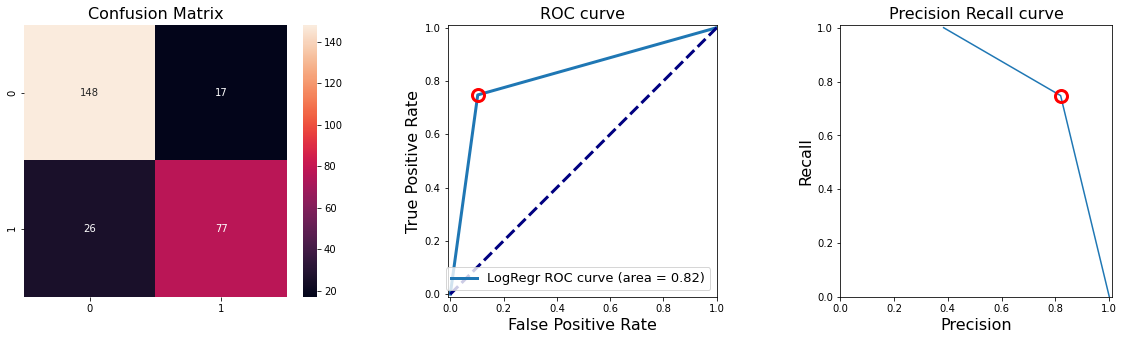

Wall time: 856 ms


In [74]:
%%time
gbc, gbc_acc = predict(gs_GBC,1)

# Submission

In [77]:
# Make predictions
predictions = gbc.predict(X_test_)

# Format correctly in new DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=['Survived'],
                             index=X_test_.index,
                             data=predictions)

# Save prediction_df to csv called "predictions.csv"
prediction_df.to_csv("Datasets/predictions.csv")

In [78]:
prediction_df.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


# Submission scored

- 0.77511